In [23]:
!pip install --quiet torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time

!pip install --quiet --upgrade "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import HW01
HW01.check_install(requires="0.7.1")

[DONE] Install ok. Version is v0.7.1


In [24]:
import torch
import torch.nn as nn

## Charger et modifier le modèle Deit pré-entraîné

model_deit = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

# Modifier la dernière couche pour avoir 2 sorties (tumeur vs non-tumeur)
in_features = model_deit.head.in_features
model_deit.head = nn.Linear(in_features, 2)

# Vérifier la nouvelle architecture
print(model_deit)



Using cache found in /Users/arthurgontier/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


# Génération du Dataset PCAM et transformation des inputs pour l'adapter à Deit

In [38]:
## Downlading the data

data_train = HW01.PCAM(root='./data', split='val', download=True)
data_test = HW01.PCAM(root='./data', split='test', download=True)

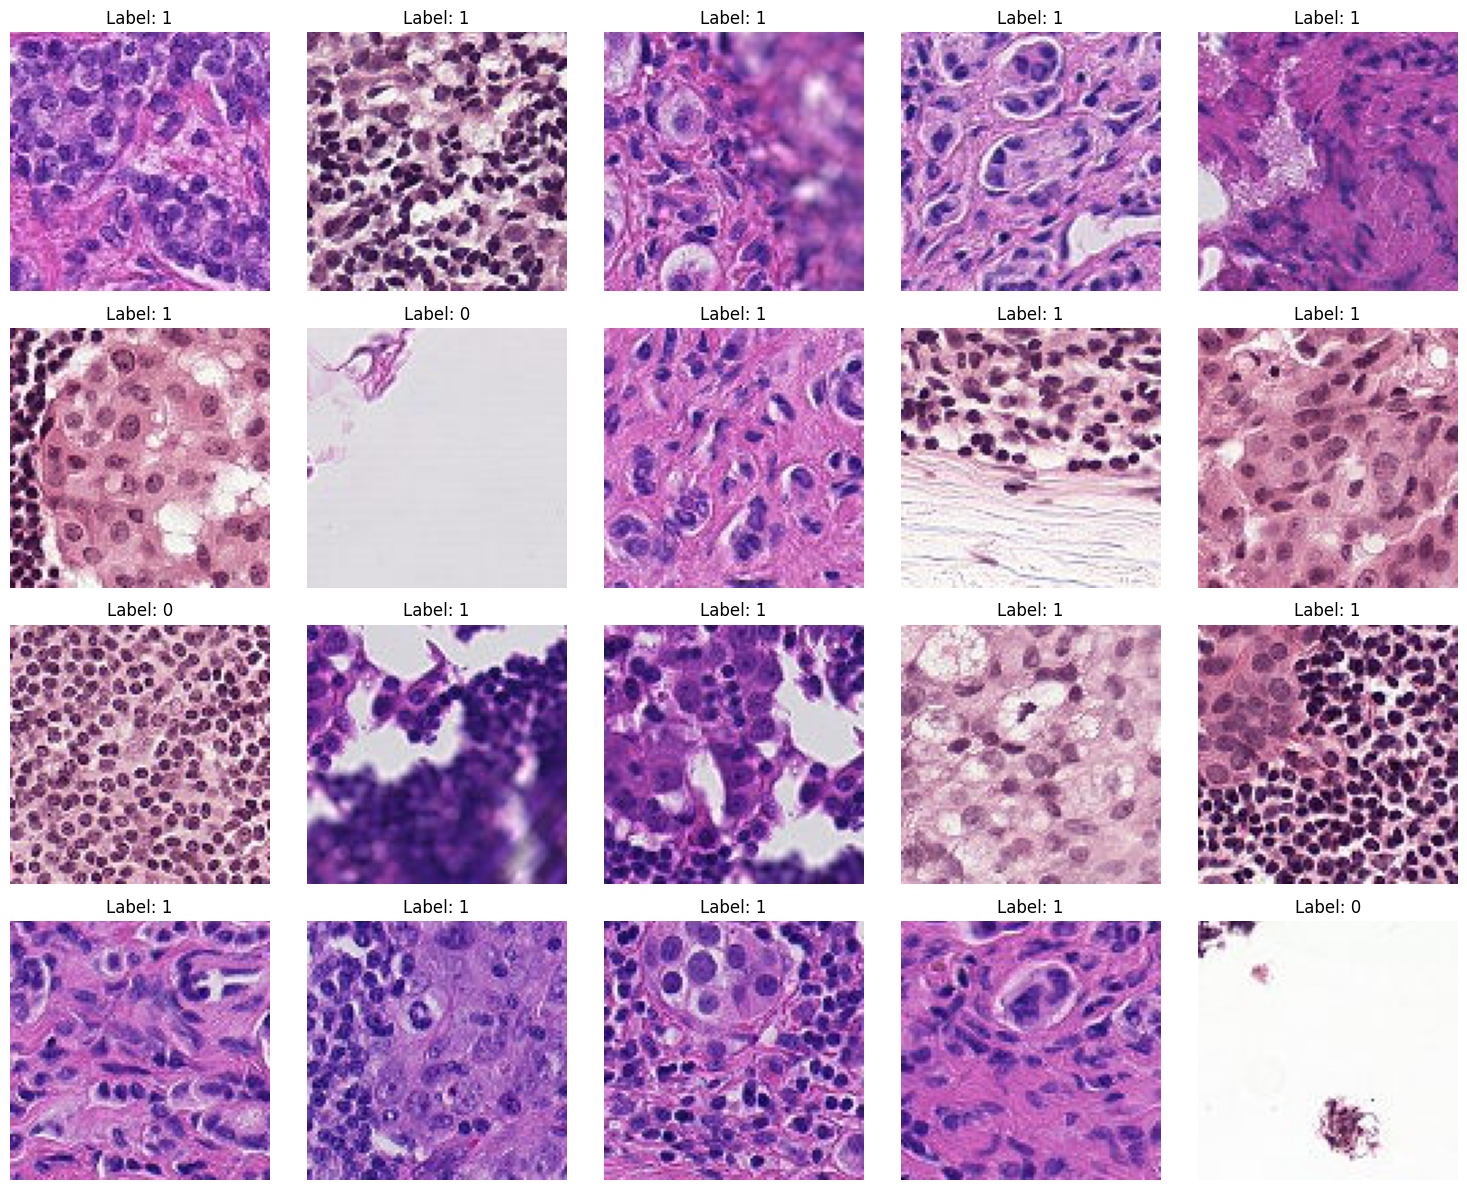

In [40]:
## Afficher des exemples d'images tumorales

# Définir le nombre d'images à afficher et la grille (4 lignes x 5 colonnes)
num_images = 20
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

for idx in range(num_images):
    # Calcul de la position dans la grille
    row = idx // cols
    col = idx % cols
    
    image, label = data_train[idx]
    
    # Si l'image est un tensor, on ajuste les dimensions pour l'affichage
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()



In [41]:
## Transforming images into tensors

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_train.transform = transform
data_test.transform = transform

print("Train set size:", len(data_train))
print("Test set size:", len(data_test))
print()
print("Size of the images in the training test", data_train[0][0].shape)
print("Size of the images in the testing test", data_test[0][0].shape)

Train set size: 32768
Test set size: 32768

Size of the images in the training test torch.Size([3, 224, 224])
Size of the images in the testing test torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9306722..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5455182..2.64].
Clipping input data 

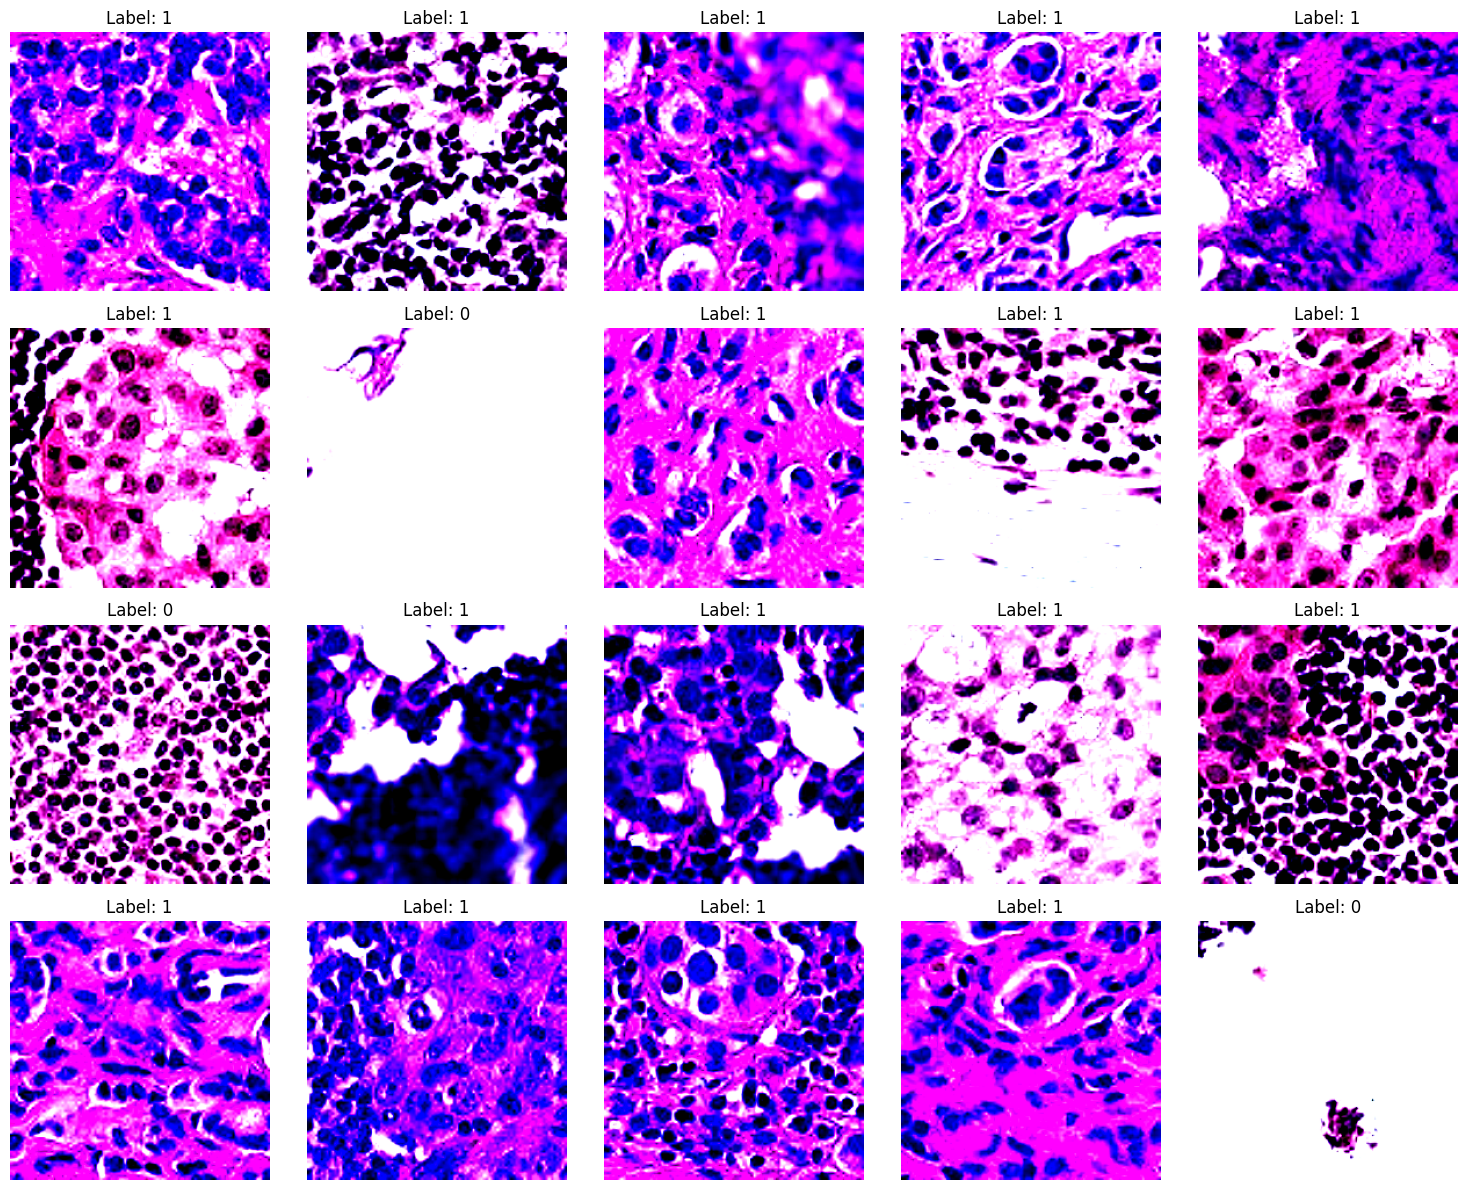

In [42]:
## Afficher des exemples d'images tumorales

# Définir le nombre d'images à afficher et la grille (4 lignes x 5 colonnes)
num_images = 20
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

for idx in range(num_images):
    # Calcul de la position dans la grille
    row = idx // cols
    col = idx % cols
    
    image, label = data_train[idx]
    
    # Si l'image est un tensor, on ajuste les dimensions pour l'affichage
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [43]:
## Creating dataloader

from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

print("Number of mini-batches in the training set:", len(train_loader))
print("Number of mini-batches in the testing set:", len(test_loader))

Number of mini-batches in the training set: 512
Number of mini-batches in the testing set: 512


In [44]:
## Training loop

lr = 1e-3
weight_decay = 1e-1

def train_model(model, dataloader, epochs):
  model.to(device)
  model.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  n_data = len(dataloader.dataset)
  losses = []
  accuracies = []
  epoch_times = []

  for epoch in range(epochs):
    running_loss, running_acc = 0., 0
    for inputs, targets in dataloader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      preds = torch.argmax(outputs, dim=1)
      running_loss += loss.item()
      running_acc += torch.sum(preds == targets)
    print(f"Epoch {epoch+1}: Loss: {running_loss/n_data:.2f} Acc: {running_acc/n_data:.2f}")

    losses.append(running_loss/n_data)
    accuracies.append(running_acc/n_data)
    epoch_times.append(epoch+1)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  ax1.bar(epoch_times, losses, color="tab:red", alpha = 0.7)
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss", color="tab:red")


  ax2.bar(epoch_times, [acc.cpu().numpy() for acc in accuracies], color="tab:blue", alpha=0.7)
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy", color="tab:blue")

  fig.suptitle("Loss and Accuracy over Epochs")
  plt.show()

In [45]:
## Testing loop

def test_model(model, dataloader):
  model.to(device)
  model.eval()
  running_loss, running_acc = 0., 0
  n_data = len(dataloader.dataset)
  criterion = nn.CrossEntropyLoss()

  with torch.no_grad():

    for inputs, targets in dataloader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      preds = torch.argmax(outputs,1)
      running_loss += loss.item()
      running_acc += torch.sum(preds == targets)


  loss_value = running_loss/n_data
  acc_value = running_acc/n_data

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  ax1.bar("Loss", loss_value, color="tab:red", width=0.4, label="Loss")
  ax1.set_ylabel("Loss", color="tab:red")
  ax1.tick_params(axis="y", labelcolor="tab:red")


  ax2.bar("Accuracy", acc_value.cpu().numpy(), color="tab:blue", width=0.4, label="Accuracy")
  ax2.set_ylabel("Accuracy (%)", color="tab:blue")
  ax2.tick_params(axis="y", labelcolor="tab:blue")

  plt.title("Loss and Accuracy")
  plt.show()




# Entraînement du modèle Deit sur le dataset PCAM

In [46]:
# 1. Geler tous les paramètres du modèle
for param in model_deit.parameters():
    param.requires_grad = False

# 2. Dé-geler uniquement la nouvelle tête (head)
for param in model_deit.head.parameters():
    param.requires_grad = True

# Ensuite, lors de la création de l'optimiseur, on passe seulement les paramètres dé-gelés :
optimizer = torch.optim.Adam(model_deit.head.parameters(), lr=lr, weight_decay=weight_decay)


In [49]:
from torch.utils.data import TensorDataset, DataLoader

def precompute_deit_tiny_features(model, dataloader):
    model.eval()
    model.to(device)
    list_outputs = []
    list_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Utilisation de forward_features pour extraire les représentations intermédiaires
            features = model.forward_features(inputs)
            list_outputs.append(features)
            list_labels.append(labels)

    outputs = torch.cat(list_outputs, dim=0)
    labels = torch.cat(list_labels, dim=0)
    
    return TensorDataset(outputs, labels)





In [ ]:
# Après avoir chargé/initialisé le modèle
# Geler tous les paramètres
for param in model_deit.parameters():
    param.requires_grad = False

# Réactiver la mise à jour pour la dernière couche (par exemple, model_deit.head)
for param in model_deit.head.parameters():
    param.requires_grad = True

# Maintenant, vous pouvez pré-calculer les features
precomputed_train_dataset = precompute_deit_tiny_features(model_deit, train_loader)
precomputed_test_dataset = precompute_deit_tiny_features(model_deit, test_loader)

precomputed_train_loader = DataLoader(precomputed_train_dataset, batch_size=batch_size, shuffle=True)
precomputed_test_loader = DataLoader(precomputed_test_dataset, batch_size=batch_size, shuffle=False)




In [ ]:

# Ensuite, vous entraînez uniquement la tête
train_model(model_deit.head, precomputed_train_loader, epochs)
test_model(model_deit.head, precomputed_test_loader)